In [10]:
# Installing gensim
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 19.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
open

In [1]:
# importing necessary libraries
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D

In [ ]:
# Load dataset
# text cleaning
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df['sentiment'] = df['sentiment'].map({'negative':0, 'positive':1}).astype(int)

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
nonalpha = re.compile(r'[^a-z\s]')

def clean_text(t):
    t = t.lower()
    t = re.sub(r'<.*?>|http\S+|www\S+', ' ', t)
    t = nonalpha.sub(' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return ' '.join(w for w in t.split() if w not in stop_words)

df['clean'] = df['review'].astype(str).apply(clean_text)
df = df[df['clean'].str.len() > 0]

In [ ]:
# Split, Tokenize
# Train Word2Vec on tokens 

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'])
train_df, val_df  = train_test_split(train_df, test_size=0.2, stratify=train_df['sentiment'])

tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['clean'])

def to_pad(texts, max_len=120):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_len, padding='post', truncating='post')

X_train = to_pad(train_df['clean'])
X_val   = to_pad(val_df['clean'])
X_test  = to_pad(test_df['clean'])
y_train = train_df['sentiment'].values
y_val   = val_df['sentiment'].values
y_test  = test_df['sentiment'].values

tokens_train = [s.split() for s in train_df['clean']]
w2v = Word2Vec(sentences=tokens_train, vector_size=150, window=5, min_count=2, workers=4, epochs=10)

word_index = tokenizer.word_index
vocab_size = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, 150), dtype='float32')
for w, i in word_index.items():
    if i < vocab_size and w in w2v.wv:
        embedding_matrix[i] = w2v.wv[w]

In [4]:
# Build BiLSTM model
model = Sequential([
    Embedding(vocab_size, 150, weights=[embedding_matrix], input_length=120, trainable=True),
    Bidirectional(LSTM(96, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(0.35),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 731ms/step - accuracy: 0.7463 - loss: 0.4869 - val_accuracy: 0.8662 - val_loss: 0.3104
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 191s 764ms/step - accuracy: 0.8838 - loss: 0.2779 - val_accuracy: 0.8831 - val_loss: 0.2760
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 185s 741ms/step - accuracy: 0.9116 - loss: 0.2221 - val_accuracy: 0.8767 - val_loss: 0.2912
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 751ms/step - accuracy: 0.9436 - loss: 0.1571 - val_accuracy: 0.8800 - val_loss: 0.2968
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 747ms/step - accuracy: 0.9643 - loss: 0.1074 - val_accuracy: 0.8777 - val_loss: 0.3385
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 184s 735ms/step - accuracy: 0.9776 - loss: 0.0685 - val_accuracy: 0.8780 - val_loss: 0.3959
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 757ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.8725 - val_loss: 0.5076
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 749ms/step - accuracy: 0.9911 -

In [5]:
# Evaluate
y_prob = model.predict(X_test, batch_size=128)
y_pred = (y_prob >= 0.5).astype(int).ravel()

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=4))

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step
Test Accuracy: 0.8784
              precision    recall  f1-score   support

           0     0.8838    0.8714    0.8775      5000
           1     0.8732    0.8854    0.8792      5000

    accuracy                         0.8784     10000
   macro avg     0.8785    0.8784    0.8784     10000
weighted avg     0.8785    0.8784    0.8784     10000



In [ ]:
# model performance & eda
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

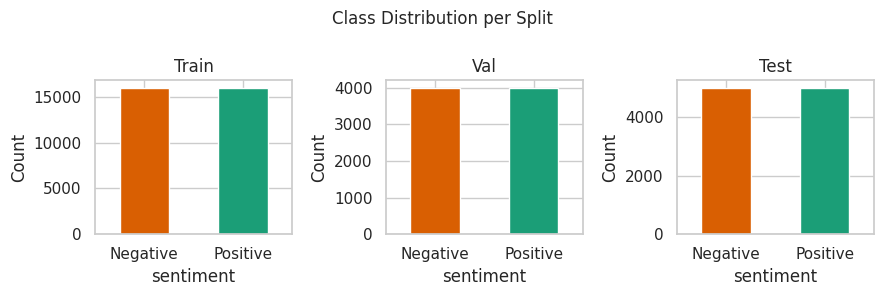

In [11]:
# class distribution
fig, ax = plt.subplots(1, 3, figsize=(9,3))
for a, split, name in zip(ax, [train_df, val_df, test_df], ["Train","Val","Test"]):
    split['sentiment'].value_counts().sort_index().plot(kind='bar', ax=a, color=['#d95f02','#1b9e77'])
    a.set_title(f'{name}')
    a.set_xticklabels(['Negative','Positive'], rotation=0)
    a.set_ylabel('Count')
fig.suptitle('Class Distribution per Split', fontsize=12)
plt.tight_layout()
plt.show()

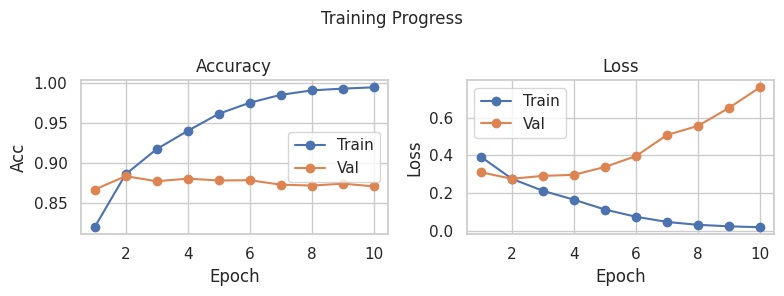

In [13]:
# Training curves (Accuracy & Loss)
hist = history.history
epochs = range(1, len(hist['accuracy'])+1)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(epochs, hist['accuracy'], label='Train', marker='o')
ax[0].plot(epochs, hist['val_accuracy'], label='Val', marker='o')
ax[0].set_title('Accuracy'); ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Acc'); ax[0].legend()
ax[1].plot(epochs, hist['loss'], label='Train', marker='o')
ax[1].plot(epochs, hist['val_loss'], label='Val', marker='o')
ax[1].set_title('Loss'); ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Loss'); ax[1].legend()
fig.suptitle('Training Progress', fontsize=12)
plt.tight_layout()
plt.show()

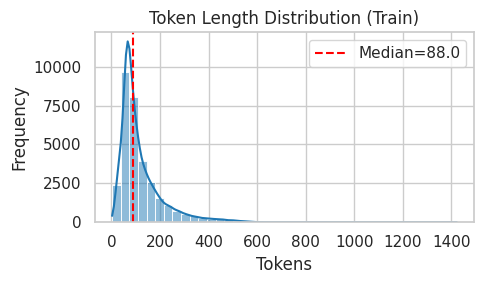

In [ ]:
# token length distribution
train_lengths = train_df['clean'].str.split().apply(len)
plt.figure(figsize=(5,3))
sns.histplot(train_lengths, bins=40, kde=True, color='#1f78b4')
plt.axvline(train_lengths.median(), color='red', linestyle='--', label=f"Median={train_lengths.median()}")
plt.title('Token Length Distribution (Train)')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

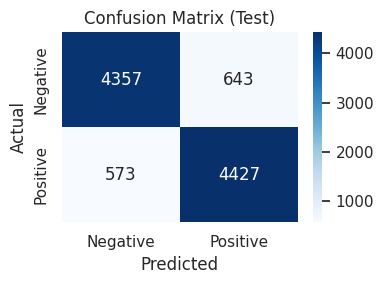

In [ ]:
# Confusion matrix (Test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()